<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/notebooks/covid-19-metaculus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install [Ergo](https://github.com/oughtinc/ergo) (our forecasting library) and a few tools we'll use in this colab:

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@6396f5ec4a73a18d36faa1651b1cd9ad852f916e
!pip install --quiet pendulum seaborn

     |████████████████████████████████| 225kB 1.4MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 112kB 5.8MB/s 
     |████████████████████████████████| 2.7MB 4.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 1.4MB/s 
     |████████████████████████████████| 29.3MB 145kB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 501kB 52.6MB/s 
     |████████████████████████████████| 491kB 52.4MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


In [0]:
%load_ext google.colab.data_table

In [0]:
import re
import ergo
import pendulum
import pandas
import seaborn

from ergo import logistic

from types import SimpleNamespace
from typing import List
from pendulum import DateTime
from matplotlib import pyplot

# Questions

Here are Metaculus ids for the questions we'll load, and some short names that will allow us to associate questions with variables in our model:

In [0]:
question_ids = [3704, 3712, 3713, 3711, 3722, 3761, 3705, 3706]
question_names = [
  "WHO Eastern Mediterranean Region on 2020/03/27",
  "WHO Region of the Americas on 2020/03/27",
  "WHO Western Pacific Region on 2020/03/27",
  "WHO South-East Asia Region on 2020/03/27",
  "South Korea on 2020/03/27",
  "United Kingdom on 2020/03/27",
  "WHO African Region on 2020/03/27",
  "WHO European Region on 2020/03/27"
]

We load the question data from Metaculus:

In [0]:
metaculus = ergo.Metaculus(username="ought", password="")
questions = [metaculus.get_question(id, name=name) for id, name in zip(question_ids, question_names)]
ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3704,WHO Eastern Mediterranean Region on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 09:00:00+00:00
1,3712,WHO Region of the Americas on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 21:37:00+00:00
2,3713,WHO Western Pacific Region on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 09:00:00+00:00
3,3711,WHO South-East Asia Region on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 21:43:00+00:00
4,3722,South Korea on 2020/03/27,How many COVID-2019 cases in South Korea will ...,2020-03-27 21:41:00+00:00
5,3761,United Kingdom on 2020/03/27,How many COVID-2019 cases in the United Kingdo...,2020-03-27 09:00:00+00:00
6,3705,WHO African Region on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 09:00:00+00:00
7,3706,WHO European Region on 2020/03/27,How many total confirmed cases of novel corona...,2020-03-27 09:00:00+00:00


# Data

Our most important data is the data about confirmed cases (from Hopkins):

In [0]:
confirmed_infections = ergo.data.covid19.ConfirmedInfections()

# Assumptions

Assumptions are things that should be inferred from data but currently aren't:

In [0]:
assumptions = SimpleNamespace()

We'll manually add some data about [doubling times](https://ourworldindata.org/coronavirus#the-growth-rate-of-covid-19-deaths) (in days):

In [0]:
assumptions.doubling_time = {
  "World": 8,
  "China": 33,
  "Italy": 4,
  "Iran": 5,
  "Spain": 3,
  "France": 4,
  "United States": 3,
  "United Kingdom": 3,
  "South Korea": 12,
  "Netherlands": 1,
  "Japan": 8,
  "Switzerland": 5,
  "Philippines": 4,
  "Belgium": 1,
  "San Marino": 3,
  "Germany": 5,
  "Iraq": 8,
  "Sweden": 3,
  "Canada": 2,
  "Algeria": 4,
  "Australia": 4,
  "Egypt": 2,
  "Greece": 5,
  "Indonesia": 7,
  "Poland": 5
}

To estimate doubling times for places where we don't have data we'll specify which places are similar to which other places:

In [0]:
assumptions.similar_areas = {
  "Bay Area": ["United States", "Italy"],
  "San Francisco": ["United States", "Italy"],
  "WHO Eastern Mediterranean Region": ["Iraq", "Iran"],
  "WHO Region of the Americas": ["United States"],
  "WHO Western Pacific Region": ["United States", "Italy", "Spain", "South Korea"],
  "WHO South-East Asia Region": ["South Korea", "China", "Japan", "Philippines", "Indonesia"],
  "South Korea": ["South Korea"],
  "United Kingdom": ["United Kingdom"],
  "WHO African Region": ["Algeria"],
  "WHO European Region": ["Italy", "Spain","France","Germany","Greece"], # "Belgium",
}

# Model

Main model:

In [0]:
Area = str

def get_doubling_time(area: Area):
  similar_areas = assumptions.similar_areas[area]
  doubling_times = [assumptions.doubling_time[proxy] for proxy in similar_areas]
  proxy_doubling_time = ergo.random_choice(doubling_times)
  doubling_time = ergo.lognormal_from_interval(proxy_doubling_time - 0.5, proxy_doubling_time + 0.5)
  return doubling_time

def model(start: DateTime, end: DateTime, areas: List[Area]):
  for area in areas:
    doubling_time = get_doubling_time(area)
    confirmed = confirmed_infections(area, start)
    for i in range((end - start).days):
      date = start.add(days=i)
      confirmed = confirmed * 2**(1 / doubling_time)
      ergo.tag(confirmed, f"{area} on {date.format('YYYY/MM/DD')}")

Run the model:

In [0]:
# Model parameters
start_date = pendulum.now(tz="US/Pacific").subtract(days = 10)
end_date = max(question.resolve_time for question in questions).add(days = 3)
areas = [re.match("(.*)? on", name).groups()[0] for name in question_names]

# Get samples from model for all variables
samples = ergo.run(lambda: model(start_date, end_date, areas), num_samples=5000)

100%|██████████| 5000/5000 [01:08<00:00, 73.24it/s]


# Analysis

Look at raw samples from the model:

In [0]:
samples

,WHO Eastern Mediterranean Region on 2020/03/23,WHO Eastern Mediterranean Region on 2020/03/24,WHO Eastern Mediterranean Region on 2020/03/25,WHO Eastern Mediterranean Region on 2020/03/26,WHO Eastern Mediterranean Region on 2020/03/27,WHO Eastern Mediterranean Region on 2020/03/28,WHO Region of the Americas on 2020/03/23,WHO Region of the Americas on 2020/03/24,WHO Region of the Americas on 2020/03/25,WHO Region of the Americas on 2020/03/26,WHO Region of the Americas on 2020/03/27,WHO Region of the Americas on 2020/03/28,WHO Western Pacific Region on 2020/03/23,WHO Western Pacific Region on 2020/03/24,WHO Western Pacific Region on 2020/03/25,WHO Western Pacific Region on 2020/03/26,WHO Western Pacific Region on 2020/03/27,WHO Western Pacific Region on 2020/03/28,WHO South-East Asia Region on 2020/03/23,WHO South-East Asia Region on 2020/03/24,WHO South-East Asia Region on 2020/03/25,WHO South-East Asia Region on 2020/03/26,WHO South-East Asia Region on 2020/03/27,WHO South-East Asia Region on 2020/03/28,South Korea on 2020/03/23,South Korea on 2020/03/24,South Korea on 2020/03/25,South Korea on 2020/03/26,South Korea on 2020/03/27,South Korea on 2020/03/28,United Kingdom on 2020/03/23,United Kingdom on 2020/03/24,United Kingdom on 2020/03/25,United Kingdom on 2020/03/26,United Kingdom on 2020/03/27,United Kingdom on 2020/03/28,WHO African Region on 2020/03/23,WHO African Region on 2020/03/24,WHO African Region on 2020/03/25,WHO African Region on 2020/03/26,WHO African Region on 2020/03/27,WHO African Region on 2020/03/28,WHO European Region on 2020/03/23,WHO European Region on 2020/03/24,WHO European Region on 2020/03/25,WHO European Region on 2020/03/26,WHO European Region on 2020/03/27,WHO European Region on 2020/03/28
0,31284.689453,36086.269531,41624.796875,48013.378906,55382.480469,63882.593750,66987.906250,86065.695312,110576.734375,142068.390625,182528.703125,234511.890625,17301.283203,20394.792969,24041.429688,28340.093750,33407.371094,39380.687500,2343.000732,2819.544189,3393.011963,4083.117432,4913.583496,5912.958496,9475.372070,10019.269531,10594.387695,11202.517578,11845.555664,12525.504883,8016.653809,9554.971680,11388.477539,13573.815430,16178.498047,19282.994141,1415.350952,1650.097412,1923.778320,2242.851318,2614.844971,3048.536377,237329.953125,283584.28125,338853.31250,404893.96875,483805.59375,578096.68750
1,29549.523438,32194.320312,35075.835938,38215.257812,41635.671875,45362.226562,63345.941406,76961.742188,93504.171875,113602.289062,138020.359375,167686.937500,17154.404297,20049.982422,23434.318359,27389.914062,32013.193359,37416.859375,1988.752075,2031.399536,2074.961426,2119.457520,2164.907959,2211.333008,9491.422852,10053.243164,10648.319336,11278.619141,11946.227539,12653.353516,8948.615234,11905.696289,15839.948242,21074.279297,28038.300781,37303.593750,1437.368408,1701.835083,2014.962036,2385.702393,2824.656494,3344.375488,228382.687500,262605.25000,301955.96875,347203.28125,399230.78125,459054.46875
2,31013.890625,35464.250000,40553.214844,46372.425781,53026.667969,60635.765625,64775.937500,80475.687500,99980.593750,124212.906250,154318.406250,191720.578125,17435.996094,20713.630859,24607.398438,29233.119141,34728.386719,41256.660156,1988.107788,2030.083496,2072.945557,2116.712402,2161.403320,2207.037842,9500.553711,10072.594727,10679.079102,11322.080078,12003.796875,12726.561523,8191.193359,9975.564453,12148.643555,14795.106445,18018.076172,21943.136719,1436.707153,1700.269653,2012.182495,2381.315430,2818.165527,3335.155273,233761.734375,275121.06250,323798.09375,381087.53125,448513.15625,527868.37500
3,31200.568359,35892.464844,41289.921875,47499.042969,54641.882812,62858.851562,67609.257812,87669.718750,113682.359375,147413.250000,191152.500000,247869.703125,15558.686523,16493.337891,17484.136719,18534.455078,19647.869141,20828.167969,2362.387939,2866.397949,3477.937256,4219.947266,5120.263184,6212.659180,9506.293945,10084.770508,10698.448242,11349.469727,12040.106445,12772.770508,8586.582031

Summary stats:

In [0]:
samples.describe()

,WHO Eastern Mediterranean Region on 2020/03/23,WHO Eastern Mediterranean Region on 2020/03/24,WHO Eastern Mediterranean Region on 2020/03/25,WHO Eastern Mediterranean Region on 2020/03/26,WHO Eastern Mediterranean Region on 2020/03/27,WHO Eastern Mediterranean Region on 2020/03/28,WHO Region of the Americas on 2020/03/23,WHO Region of the Americas on 2020/03/24,WHO Region of the Americas on 2020/03/25,WHO Region of the Americas on 2020/03/26,WHO Region of the Americas on 2020/03/27,WHO Region of the Americas on 2020/03/28,WHO Western Pacific Region on 2020/03/23,WHO Western Pacific Region on 2020/03/24,WHO Western Pacific Region on 2020/03/25,WHO Western Pacific Region on 2020/03/26,WHO Western Pacific Region on 2020/03/27,WHO Western Pacific Region on 2020/03/28,WHO South-East Asia Region on 2020/03/23,WHO South-East Asia Region on 2020/03/24,WHO South-East Asia Region on 2020/03/25,WHO South-East Asia Region on 2020/03/26,WHO South-East Asia Region on 2020/03/27,WHO South-East Asia Region on 2020/03/28,South Korea on 2020/03/23,South Korea on 2020/03/24,South Korea on 2020/03/25,South Korea on 2020/03/26,South Korea on 2020/03/27,South Korea on 2020/03/28,United Kingdom on 2020/03/23,United Kingdom on 2020/03/24,United Kingdom on 2020/03/25,United Kingdom on 2020/03/26,United Kingdom on 2020/03/27,United Kingdom on 2020/03/28,WHO African Region on 2020/03/23,WHO African Region on 2020/03/24,WHO African Region on 2020/03/25,WHO African Region on 2020/03/26,WHO African Region on 2020/03/27,WHO African Region on 2020/03/28,WHO European Region on 2020/03/23,WHO European Region on 2020/03/24,WHO European Region on 2020/03/25,WHO European Region on 2020/03/26,WHO European Region on 2020/03/27,WHO European Region on 2020/03/28
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03
mean,30368.264766,34027.995507,38156.771516,42817.969782,48083.894137,54037.072045,66012.096283,83625.616505,106001.536891,134444.835430,170622.932270,216667.742769,17583.856575,21176.537805,25628.920423,31160.649904,38049.513093,46647.230893,2130.586570,2337.905727,2572.642439,2839.120701,3142.421821,3488.525483,9494.443282,10059.663995,10658.556426,11293.127865,11965.505379,12677.942876,8517.299067,10791.921113,13681.997071,17356.260104,22030.320476,27979.863708,1446.502711,1723.845592,2054.736955,2449.588166,2920.849036,3483.409719,236391.788137,281780.096262,336419.359600,402317.206925,4.819448e+05,5.783501e+05
std,822.146006,1845.313173,3107.440698,4653.015973,6534.163864,8811.914437,1599.897143,4071.713624,7779.826948,13227.199067,21106.066599,32366.936297,1271.360096,2983.435130,5273.083184,8320.034909,12360.553963,17705.502072,111.829404,248.952224,416.779004,621.861751,872.131136,1177.182997,13.993691,29.655296,47.134072,66.591155,88.200434,112.149551,205.149638,522.205570,997.856983,1696.452206,2706.385491,4148.745656,19.455845,46.441789,83.167463,132.425110,197.735185,283.527238,9279.139946,22546.015072,41161.330471,66922.424208,1.022020e+05,1.501317e+05
min,29277.867188,31605.099609,34117.320312,36829.230469,39756.703125,42916.875000,61311.925781,72098.664062,84783.140625,99699.218750,117239.515625,137865.718750,15482.545898,16332.303711,17228.701172,18174.296875,19171.791016,20224.033203,1987.271240,2028.375488,2070.329834,2113.152100,2156.860107,2201.472168,9445.649414,9956.510742,10495.001953,11062.617188,11660.930664,12291.603516,7936.103027,9363.920898,11048.624023,13036.428711,15381.868164,18149.285156,1373.731567,155

Plot some marginals:

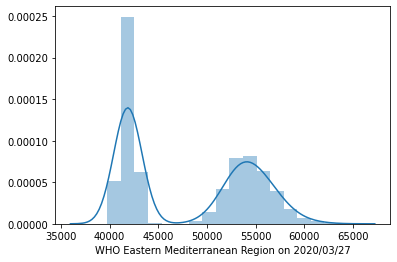

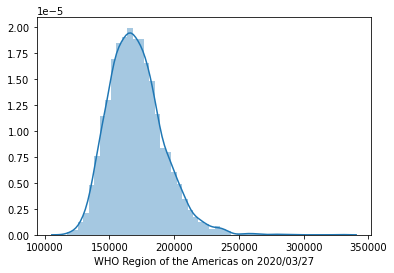

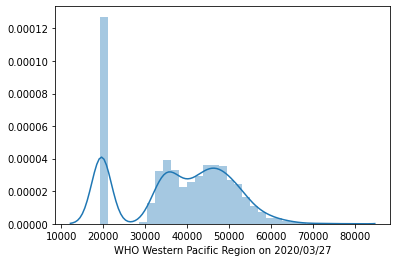

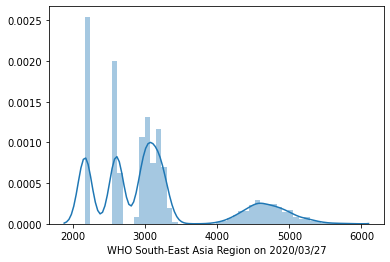

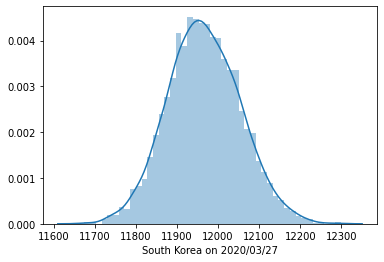

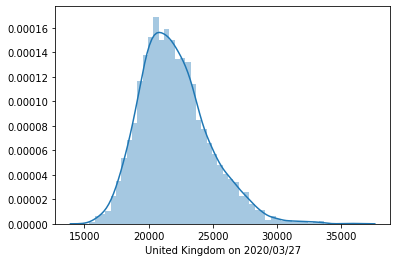

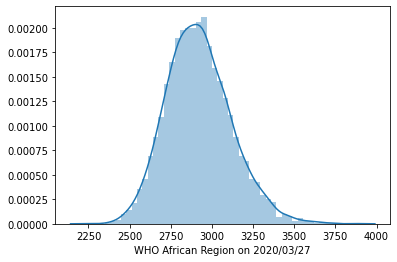

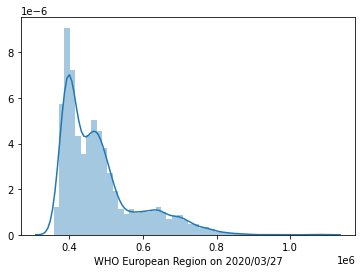

In [0]:
for question in questions:
  pyplot.figure()
  seaborn.distplot(samples[question.name])

# Submit predictions

Convert samples to Metaculus distributions and submit:

In [0]:
for question in questions:
  if question.name in samples:
    params = question.submit_from_samples(samples[question.name])
    print(f"Submitted Logistic{params} for {question.name}")
  else:
    print(f"No predictions for {question.name}")